# Universidade Federal do Rio de Janeiro
## MBA Software Engineering
### Phelipe Gonçalves Martins

#### The following work contains code developed by Renu Khandelwal, Richmond Alake and Dr. Vaibhav Kumar

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from tensorflow import keras
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

from sklearn import metrics

%matplotlib inline

## Function to create confusion matrix

In [2]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#Print Confusion matrix
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

In [3]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [4]:
def plot_x_ray_chest(path):
    plt.figure(figsize=(20,20))
    img_folder=path
    for i in range(5):
        file = random.choice(os.listdir(img_folder))
        image_path= os.path.join(img_folder, file)
        img=mpimg.imread(image_path)
        ax=plt.subplot(1,5,i+1)
        ax.title.set_text(file)
        plt.imshow(img)


## COVID-19 X-ray Chest

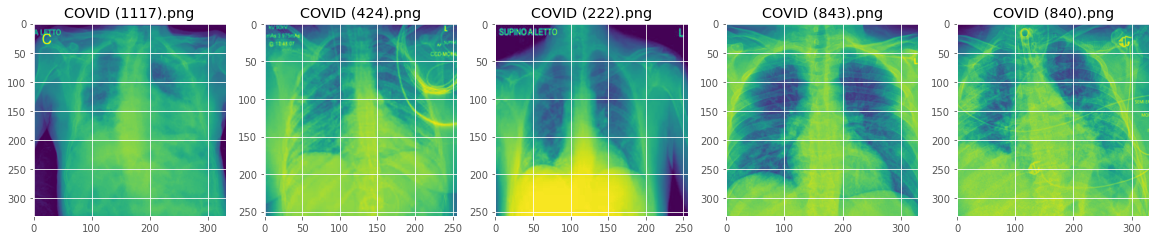

In [5]:
plot_x_ray_chest(r'COVID-19 Radiography Database\train\COVID')

## Pneumonia X-ray Chest

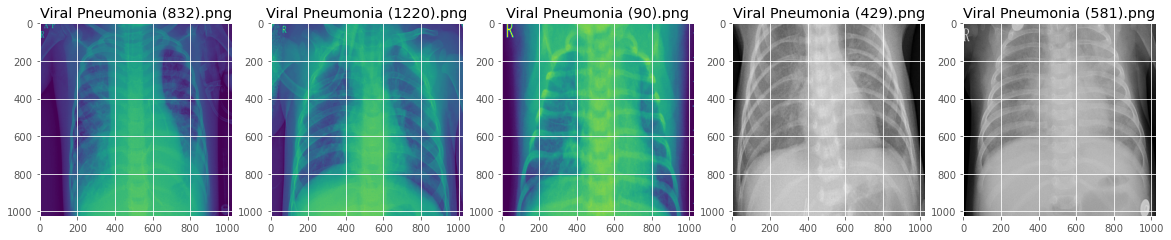

In [6]:
plot_x_ray_chest(r'COVID-19 Radiography Database\train\viral')

## Normal X-ray Chest

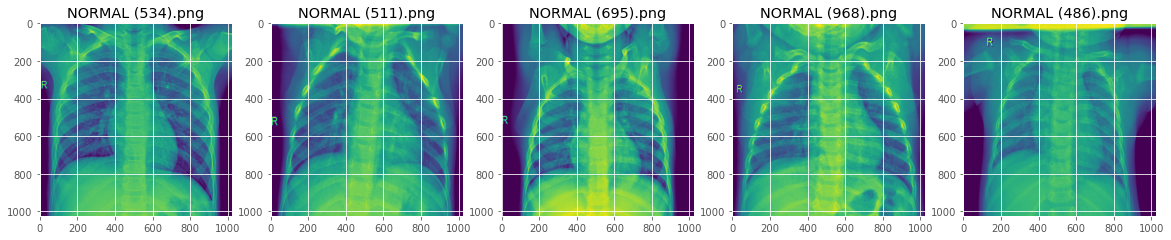

In [7]:
plot_x_ray_chest(r'COVID-19 Radiography Database\train\normal')

In [8]:
IMG_WIDTH=224
IMG_HEIGHT=224
img_folder=r'COVID-19 Radiography Database\train'

In [9]:
def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
   
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):
       
            image_path= os.path.join(img_folder, dir1,  file)
            image= cv2.imread(image_path)
            (b, g, r)=cv2.split(image)
            image=cv2.merge([r,g,b])
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image=np.array(image)
            image = image.astype('float32')
            image /= 255 
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array, class_name

## Creating Training and Testing Set

In [10]:
X, y_aux =create_dataset(r'COVID-19 Radiography Database\train')

In [11]:
len(X)

3886

In [12]:
target_dict={k: v for v, k in enumerate(np.unique(y_aux))}
target_dict

{'COVID': 0, 'normal': 1, 'viral': 2}

In [13]:
y=[target_dict[y_aux[i]] for i in range(len(y_aux))]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [15]:
#Using earling stop to see which epoch gives the better result
monitor = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

## LeNet-5 CNN

In [16]:
X_train[0].shape

(224, 224, 3)

In [63]:
lenet_5_model = keras.models.Sequential([
    keras.layers.Conv2D(6, kernel_size=5, strides=1,  activation='tanh', input_shape=X_train[0].shape, padding='same'), #C1
    keras.layers.AveragePooling2D(), #S2
    keras.layers.Conv2D(16, kernel_size=5, strides=1, activation='tanh', padding='valid'), #C3
    keras.layers.AveragePooling2D(), #S4
    keras.layers.Flatten(), #Flatten
    keras.layers.Dense(120, activation='tanh'), #C5
    keras.layers.Dense(84, activation='tanh'), #F6
    keras.layers.Dense(3, activation='softmax') #Output layer
])

## Learning Rate 0.00001

In [64]:
opt = keras.optimizers.Adam(lr=0.00001)
lenet_5_model.compile(optimizer=opt, loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [65]:
hist_lenet_5=lenet_5_model.fit(np.array(X_train, np.float32),
                   np.array(list(map(int,y_train)), np.float32),
                   epochs=1000,
                   verbose=1,
                  validation_data=(np.array(X_test, np.float32), np.array(list(map(int,y_test)), np.float32)),
                  callbacks = [monitor])

Epoch 1/1000
82/82 [==============================] - 74s 902ms/step - loss: 0.6683 - accuracy: 0.7138 - val_loss: 0.5026 - val_accuracy: 0.8106
Epoch 2/1000
82/82 [==============================] - 59s 717ms/step - loss: 0.4160 - accuracy: 0.8494 - val_loss: 0.3995 - val_accuracy: 0.8659
Epoch 3/1000
82/82 [==============================] - 61s 741ms/step - loss: 0.3468 - accuracy: 0.8859 - val_loss: 0.3542 - val_accuracy: 0.8722
Epoch 4/1000
82/82 [==============================] - 65s 792ms/step - loss: 0.3232 - accuracy: 0.8851 - val_loss: 0.3238 - val_accuracy: 0.8885
Epoch 5/1000
82/82 [==============================] - 65s 793ms/step - loss: 0.2899 - accuracy: 0.8978 - val_loss: 0.3504 - val_accuracy: 0.8714
Epoch 6/1000
82/82 [==============================] - 58s 708ms/step - loss: 0.2693 - accuracy: 0.9047 - val_loss: 0.2991 - val_accuracy: 0.8940
Epoch 7/1000
82/82 [==============================] - 57s 694ms/step - loss: 0.2500 - accuracy: 0.9182 - val_loss: 0.3068 - val_ac

Training Accuracy: 0.9481
Testing Accuracy:  0.9197


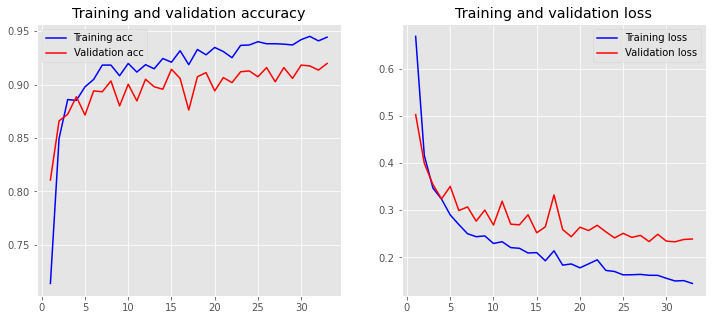

In [66]:
loss, accuracy = lenet_5_model.evaluate(np.array(X_train, np.float32), np.array(list(map(int,y_train)), np.float32), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lenet_5_model.evaluate(np.array(X_test, np.float32), np.array(list(map(int,y_test)), np.float32), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_lenet_5)

Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

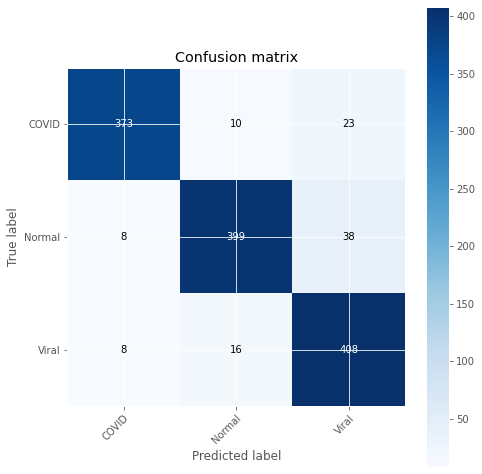

In [67]:
y_pred_lenet_5=lenet_5_model.predict_classes(np.array(X_test, np.float32))
confusion_mtx=confusion_matrix(y_test,y_pred_lenet_5)
class_names=['COVID', 'Normal', 'Viral']
plot_confusion_matrix(y_pred_lenet_5, y_test, classes = class_names,title = 'Confusion matrix')

## Learning Rate 0.0001

In [59]:
opt = keras.optimizers.Adam(lr=0.0001)
lenet_5_model.compile(optimizer=opt, loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [60]:
hist_lenet_5=lenet_5_model.fit(np.array(X_train, np.float32),
                   np.array(list(map(int,y_train)), np.float32),
                   epochs=1000,
                   verbose=1,
                  validation_data=(np.array(X_test, np.float32), np.array(list(map(int,y_test)), np.float32)),
                  callbacks = [monitor])

Epoch 1/1000
82/82 [==============================] - 56s 681ms/step - loss: 1.0566 - accuracy: 0.6312 - val_loss: 0.5685 - val_accuracy: 0.7958
Epoch 2/1000
82/82 [==============================] - 55s 670ms/step - loss: 0.4615 - accuracy: 0.8283 - val_loss: 0.4159 - val_accuracy: 0.8535
Epoch 3/1000
82/82 [==============================] - 55s 672ms/step - loss: 0.3644 - accuracy: 0.8644 - val_loss: 0.3382 - val_accuracy: 0.8823
Epoch 4/1000
82/82 [==============================] - 54s 663ms/step - loss: 0.3029 - accuracy: 0.8913 - val_loss: 0.2942 - val_accuracy: 0.8979
Epoch 5/1000
82/82 [==============================] - 55s 671ms/step - loss: 0.2486 - accuracy: 0.9063 - val_loss: 0.2793 - val_accuracy: 0.8987
Epoch 6/1000
82/82 [==============================] - 55s 665ms/step - loss: 0.2365 - accuracy: 0.9082 - val_loss: 0.2605 - val_accuracy: 0.9096
Epoch 7/1000
82/82 [==============================] - 55s 674ms/step - loss: 0.2047 - accuracy: 0.9289 - val_loss: 0.2728 - val_ac

Training Accuracy: 0.9969
Testing Accuracy:  0.9205


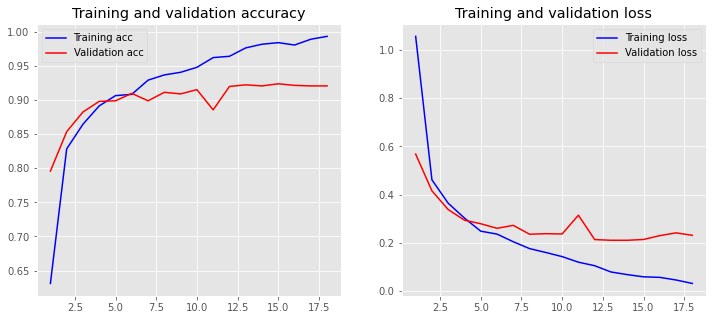

In [61]:
loss, accuracy = lenet_5_model.evaluate(np.array(X_train, np.float32), np.array(list(map(int,y_train)), np.float32), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lenet_5_model.evaluate(np.array(X_test, np.float32), np.array(list(map(int,y_test)), np.float32), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_lenet_5)

Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

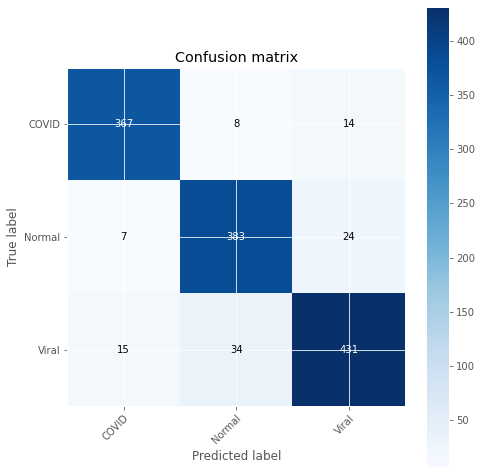

In [62]:
y_pred_lenet_5=lenet_5_model.predict_classes(np.array(X_test, np.float32))
confusion_mtx=confusion_matrix(y_test,y_pred_lenet_5)
class_names=['COVID', 'Normal', 'Viral']
plot_confusion_matrix(y_pred_lenet_5, y_test, classes = class_names,title = 'Confusion matrix')

## Learning Rate 0.001

In [125]:
opt = keras.optimizers.Adam(lr=0.001)
lenet_5_model.compile(optimizer=opt, loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [127]:
hist_lenet_5=lenet_5_model.fit(np.array(X_train, np.float32),
                   np.array(list(map(int,y_train)), np.float32),
                   epochs=1000,
                   verbose=1,
                  validation_data=(np.array(X_test, np.float32), np.array(list(map(int,y_test)), np.float32)),
                  callbacks = [monitor])

Epoch 1/1000
82/82 [==============================] - 57s 693ms/step - loss: 1.1036 - accuracy: 0.3411 - val_loss: 1.1119 - val_accuracy: 0.3289
Epoch 2/1000
82/82 [==============================] - 55s 675ms/step - loss: 1.1009 - accuracy: 0.3454 - val_loss: 1.0983 - val_accuracy: 0.3289
Epoch 3/1000
82/82 [==============================] - 56s 687ms/step - loss: 1.1006 - accuracy: 0.3408 - val_loss: 1.1025 - val_accuracy: 0.3094
Epoch 4/1000
82/82 [==============================] - 56s 687ms/step - loss: 1.1009 - accuracy: 0.3400 - val_loss: 1.1098 - val_accuracy: 0.3289
Epoch 5/1000
82/82 [==============================] - 56s 688ms/step - loss: 1.1011 - accuracy: 0.3273 - val_loss: 1.0970 - val_accuracy: 0.3617
Epoch 6/1000
82/82 [==============================] - 56s 687ms/step - loss: 1.1015 - accuracy: 0.3446 - val_loss: 1.0998 - val_accuracy: 0.3617
Epoch 7/1000
82/82 [==============================] - 56s 683ms/step - loss: 1.1072 - accuracy: 0.3338 - val_loss: 1.1000 - val_ac

Training Accuracy: 0.3546
Testing Accuracy:  0.3289


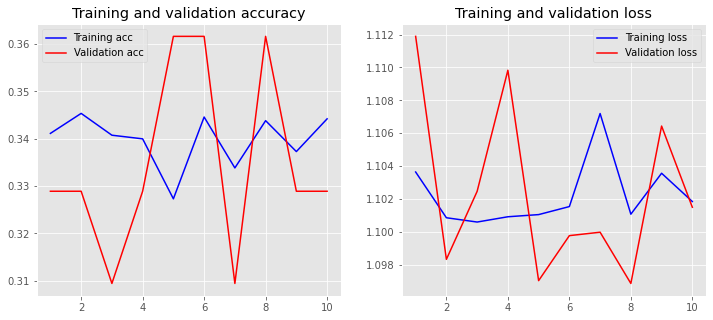

In [128]:
loss, accuracy = lenet_5_model.evaluate(np.array(X_train, np.float32), np.array(list(map(int,y_train)), np.float32), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lenet_5_model.evaluate(np.array(X_test, np.float32), np.array(list(map(int,y_test)), np.float32), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_lenet_5)

Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

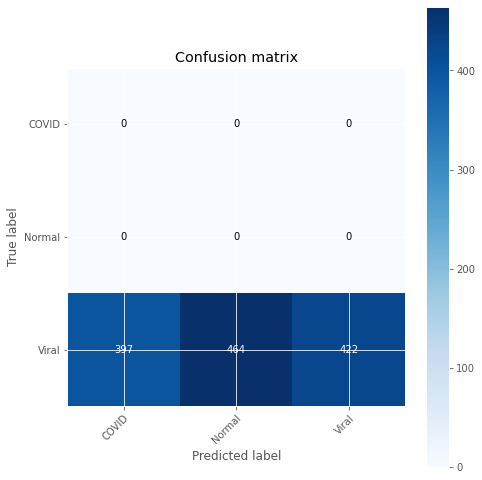

In [129]:
y_pred_lenet_5=lenet_5_model.predict_classes(np.array(X_test, np.float32))
confusion_mtx=confusion_matrix(y_test,y_pred_lenet_5)
class_names=['COVID', 'Normal', 'Viral']
plot_confusion_matrix(y_pred_lenet_5, y_test, classes = class_names,title = 'Confusion matrix')

## Learning Rate 0.01

In [18]:
opt = keras.optimizers.Adam(lr=0.01)
lenet_5_model.compile(optimizer=opt, loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [19]:
hist_lenet_5=lenet_5_model.fit(np.array(X_train, np.float32),
                   np.array(list(map(int,y_train)), np.float32),
                   epochs=1000,
                   verbose=1,
                  validation_data=(np.array(X_test, np.float32), np.array(list(map(int,y_test)), np.float32)),
                  callbacks = [monitor])

Epoch 1/1000
82/82 [==============================] - 62s 755ms/step - loss: 1.2352 - accuracy: 0.3342 - val_loss: 1.0964 - val_accuracy: 0.3655
Epoch 2/1000
82/82 [==============================] - 59s 721ms/step - loss: 1.1295 - accuracy: 0.3365 - val_loss: 1.1687 - val_accuracy: 0.3313
Epoch 3/1000
82/82 [==============================] - 68s 827ms/step - loss: 1.1347 - accuracy: 0.3411 - val_loss: 1.1150 - val_accuracy: 0.3032
Epoch 4/1000
82/82 [==============================] - 60s 732ms/step - loss: 1.1397 - accuracy: 0.3346 - val_loss: 1.1143 - val_accuracy: 0.3032
Epoch 5/1000
82/82 [==============================] - 60s 731ms/step - loss: 1.1531 - accuracy: 0.3312 - val_loss: 1.1071 - val_accuracy: 0.3655
Epoch 6/1000
82/82 [==============================] - 60s 729ms/step - loss: 1.1330 - accuracy: 0.3258 - val_loss: 1.2381 - val_accuracy: 0.3313
Epoch 00006: early stopping


Training Accuracy: 0.3519
Testing Accuracy:  0.3313


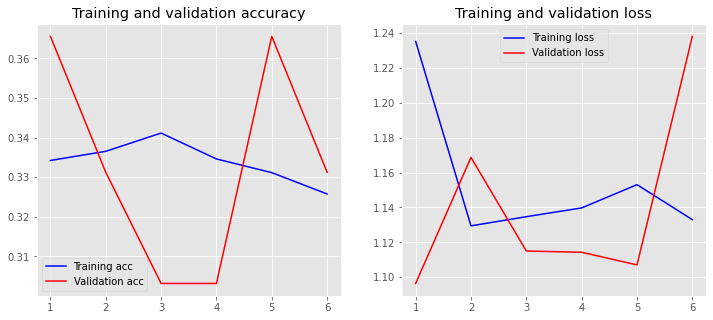

In [20]:
loss, accuracy = lenet_5_model.evaluate(np.array(X_train, np.float32), np.array(list(map(int,y_train)), np.float32), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lenet_5_model.evaluate(np.array(X_test, np.float32), np.array(list(map(int,y_test)), np.float32), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_lenet_5)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

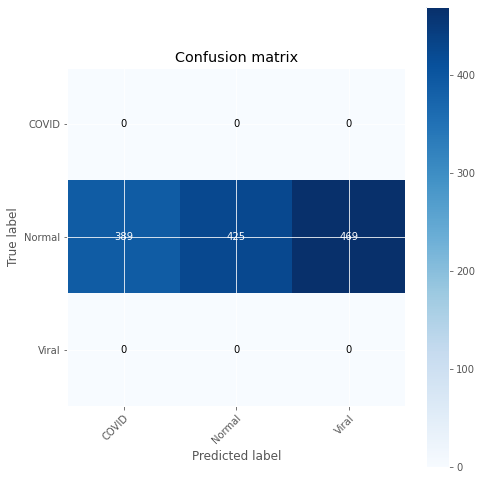

In [21]:
y_pred_lenet_5=lenet_5_model.predict_classes(np.array(X_test, np.float32))
confusion_mtx=confusion_matrix(y_test,y_pred_lenet_5)
class_names=['COVID', 'Normal', 'Viral']
plot_confusion_matrix(y_pred_lenet_5, y_test, classes = class_names,title = 'Confusion matrix')

## Learning Rate 0.1

In [22]:
opt = keras.optimizers.Adam(lr=0.1)
lenet_5_model.compile(optimizer=opt, loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [23]:
hist_lenet_5=lenet_5_model.fit(np.array(X_train, np.float32),
                   np.array(list(map(int,y_train)), np.float32),
                   epochs=1000,
                   verbose=1,
                  validation_data=(np.array(X_test, np.float32), np.array(list(map(int,y_test)), np.float32)),
                  callbacks = [monitor])

Epoch 1/1000
82/82 [==============================] - 57s 697ms/step - loss: 1.9983 - accuracy: 0.3327 - val_loss: 1.1563 - val_accuracy: 0.3313
Epoch 2/1000
82/82 [==============================] - 58s 713ms/step - loss: 1.2518 - accuracy: 0.3388 - val_loss: 1.1072 - val_accuracy: 0.3313
Epoch 3/1000
82/82 [==============================] - 58s 702ms/step - loss: 1.2449 - accuracy: 0.3392 - val_loss: 1.1195 - val_accuracy: 0.3032
Epoch 4/1000
82/82 [==============================] - 56s 683ms/step - loss: 1.3572 - accuracy: 0.3185 - val_loss: 1.1081 - val_accuracy: 0.3313
Epoch 5/1000
82/82 [==============================] - 57s 691ms/step - loss: 1.3683 - accuracy: 0.3411 - val_loss: 1.5005 - val_accuracy: 0.3655
Epoch 6/1000
82/82 [==============================] - 55s 674ms/step - loss: 1.5112 - accuracy: 0.3507 - val_loss: 1.5262 - val_accuracy: 0.3032
Epoch 7/1000
82/82 [==============================] - 60s 730ms/step - loss: 1.4529 - accuracy: 0.3250 - val_loss: 1.5648 - val_ac

Training Accuracy: 0.3365
Testing Accuracy:  0.3655


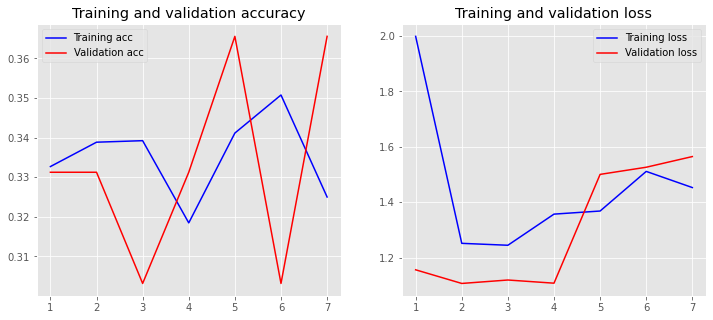

In [24]:
loss, accuracy = lenet_5_model.evaluate(np.array(X_train, np.float32), np.array(list(map(int,y_train)), np.float32), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lenet_5_model.evaluate(np.array(X_test, np.float32), np.array(list(map(int,y_test)), np.float32), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_lenet_5)

Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

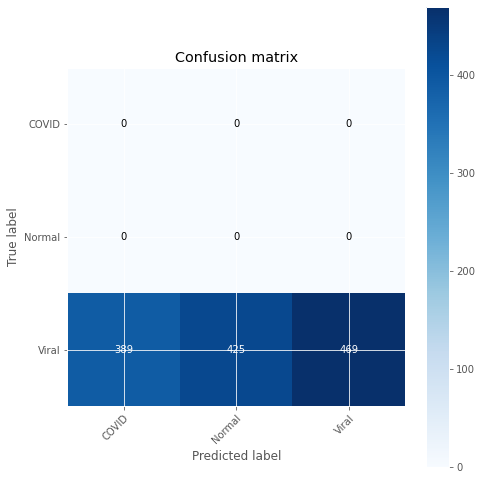

In [25]:
y_pred_lenet_5=lenet_5_model.predict_classes(np.array(X_test, np.float32))
confusion_mtx=confusion_matrix(y_test,y_pred_lenet_5)
class_names=['COVID', 'Normal', 'Viral']
plot_confusion_matrix(y_pred_lenet_5, y_test, classes = class_names,title = 'Confusion matrix')

## Learning Rate 1

In [26]:
opt = keras.optimizers.Adam(lr=1)
lenet_5_model.compile(optimizer=opt, loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [27]:
hist_lenet_5=lenet_5_model.fit(np.array(X_train, np.float32),
                   np.array(list(map(int,y_train)), np.float32),
                   epochs=1000,
                   verbose=1,
                  validation_data=(np.array(X_test, np.float32), np.array(list(map(int,y_test)), np.float32)),
                  callbacks = [monitor])

Epoch 1/1000
82/82 [==============================] - 65s 792ms/step - loss: 30.0071 - accuracy: 0.3388 - val_loss: 27.4159 - val_accuracy: 0.3655
Epoch 2/1000
82/82 [==============================] - 65s 788ms/step - loss: 25.7670 - accuracy: 0.3262 - val_loss: 53.3163 - val_accuracy: 0.3313
Epoch 3/1000
82/82 [==============================] - 60s 736ms/step - loss: 27.7222 - accuracy: 0.3358 - val_loss: 7.6960 - val_accuracy: 0.3655
Epoch 4/1000
82/82 [==============================] - 58s 705ms/step - loss: 17.2368 - accuracy: 0.3496 - val_loss: 20.6906 - val_accuracy: 0.3313
Epoch 5/1000
82/82 [==============================] - 55s 671ms/step - loss: 21.0870 - accuracy: 0.3296 - val_loss: 30.8972 - val_accuracy: 0.3032
Epoch 6/1000
82/82 [==============================] - 55s 675ms/step - loss: 16.8247 - accuracy: 0.3258 - val_loss: 41.9182 - val_accuracy: 0.3313
Epoch 7/1000
82/82 [==============================] - 56s 682ms/step - loss: 20.2436 - accuracy: 0.3446 - val_loss: 16.

Training Accuracy: 0.3116
Testing Accuracy:  0.3032


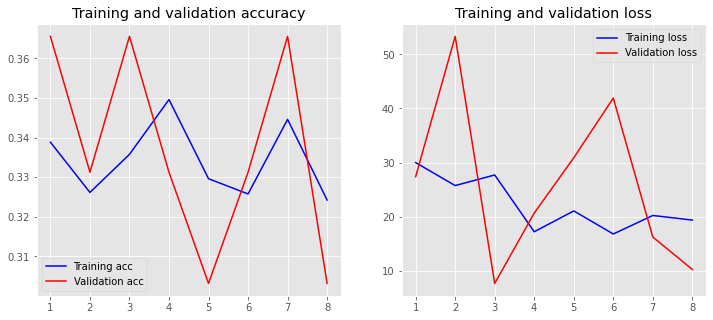

In [28]:
loss, accuracy = lenet_5_model.evaluate(np.array(X_train, np.float32), np.array(list(map(int,y_train)), np.float32), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = lenet_5_model.evaluate(np.array(X_test, np.float32), np.array(list(map(int,y_test)), np.float32), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist_lenet_5)

Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

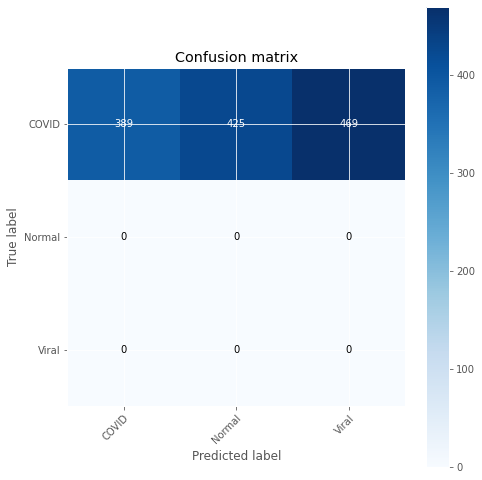

In [29]:
y_pred_lenet_5=lenet_5_model.predict_classes(np.array(X_test, np.float32))
confusion_mtx=confusion_matrix(y_test,y_pred_lenet_5)
class_names=['COVID', 'Normal', 'Viral']
plot_confusion_matrix(y_pred_lenet_5, y_test, classes = class_names,title = 'Confusion matrix')

## AlexNet

In [68]:


#Instantiation
AlexNet = keras.models.Sequential()

#1st Convolutional Layer
AlexNet.add(keras.layers.Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(keras.layers.BatchNormalization())
AlexNet.add(keras.layers.Activation('relu'))
AlexNet.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(keras.layers.BatchNormalization())
AlexNet.add(keras.layers.Activation('relu'))
AlexNet.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(keras.layers.BatchNormalization())
AlexNet.add(keras.layers.Activation('relu'))

#4th Convolutional Layer
AlexNet.add(keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(keras.layers.BatchNormalization())
AlexNet.add(keras.layers.Activation('relu'))

#5th Convolutional Layer
AlexNet.add(keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(keras.layers.BatchNormalization())
AlexNet.add(keras.layers.Activation('relu'))
AlexNet.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(keras.layers.Flatten())
# 1st Fully Connected Layer
AlexNet.add(keras.layers.Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(keras.layers.BatchNormalization())
AlexNet.add(keras.layers.Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(keras.layers.Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(keras.layers.Dense(4096))
AlexNet.add(keras.layers.BatchNormalization())
AlexNet.add(keras.layers.Activation('relu'))
#Add Dropout
AlexNet.add(keras.layers.Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(keras.layers.Dense(1000))
AlexNet.add(keras.layers.BatchNormalization())
AlexNet.add(keras.layers.Activation('relu'))
#Add Dropout
AlexNet.add(keras.layers.Dropout(0.4))

#Output Layer
AlexNet.add(keras.layers.Dense(3))
AlexNet.add(keras.layers.BatchNormalization())
AlexNet.add(keras.layers.Activation('softmax'))

In [69]:
#Model Summary
AlexNet.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization_36 (Batc (None, 56, 56, 96)        384       
_________________________________________________________________
activation_36 (Activation)   (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 28, 28, 256)       614656    
_________________________________________________________________
batch_normalization_37 (Batc (None, 28, 28, 256)       1024      
_________________________________________________________________
activation_37 (Activation)   (None, 28, 28, 256)      

## Learning Rate 0.00001

In [70]:
opt = keras.optimizers.Adam(lr=0.00001)
AlexNet.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [71]:
hist = AlexNet.fit(np.array(X_train, np.float32),
                   np.array(list(map(int,y_train)), np.float32),
                   epochs=1000,
                   verbose=1,
                  validation_data=(np.array(X_test, np.float32), np.array(list(map(int,y_test)), np.float32)),
                  callbacks = [monitor])

Epoch 1/1000
82/82 [==============================] - 251s 3s/step - loss: 0.6009 - accuracy: 0.7872 - val_loss: 1.4101 - val_accuracy: 0.3032
Epoch 2/1000
82/82 [==============================] - 253s 3s/step - loss: 0.4201 - accuracy: 0.9082 - val_loss: 1.4433 - val_accuracy: 0.3032
Epoch 3/1000
82/82 [==============================] - 265s 3s/step - loss: 0.3863 - accuracy: 0.9278 - val_loss: 1.3826 - val_accuracy: 0.3032
Epoch 4/1000
82/82 [==============================] - 257s 3s/step - loss: 0.3707 - accuracy: 0.9439 - val_loss: 1.2647 - val_accuracy: 0.4505
Epoch 5/1000
82/82 [==============================] - 251s 3s/step - loss: 0.3424 - accuracy: 0.9574 - val_loss: 1.0832 - val_accuracy: 0.5924
Epoch 6/1000
82/82 [==============================] - 253s 3s/step - loss: 0.3281 - accuracy: 0.9662 - val_loss: 0.8459 - val_accuracy: 0.6438
Epoch 7/1000
82/82 [==============================] - 257s 3s/step - loss: 0.3267 - accuracy: 0.9697 - val_loss: 0.5800 - val_accuracy: 0.7389

Training Accuracy: 1.0000
Testing Accuracy:  0.9564


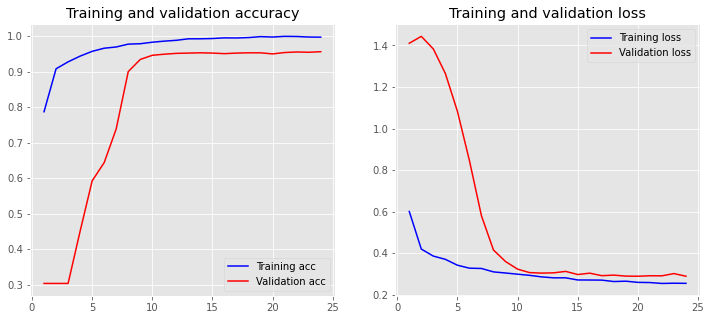

In [72]:
loss, accuracy = AlexNet.evaluate(np.array(X_train, np.float32), np.array(list(map(int,y_train)), np.float32), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = AlexNet.evaluate(np.array(X_test, np.float32), np.array(list(map(int,y_test)), np.float32), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist)

Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

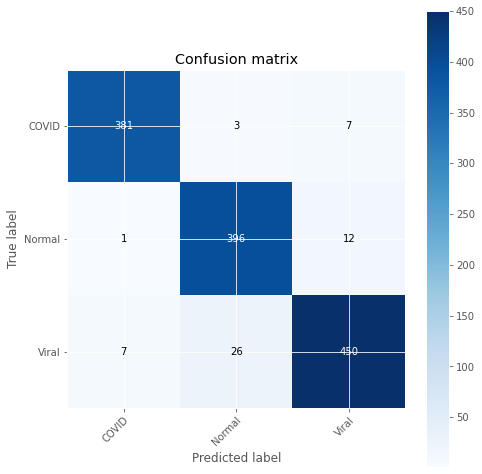

In [73]:
y_pred_AlexNet=AlexNet.predict_classes(np.array(X_test, np.float32))
confusion_mtx=confusion_matrix(y_test,y_pred_AlexNet)
class_names=['COVID', 'Normal', 'Viral']
plot_confusion_matrix(y_pred_AlexNet, y_test, classes = class_names,title = 'Confusion matrix')

## Learning Rate 0.0001

In [53]:
opt = keras.optimizers.Adam(lr=0.0001)
AlexNet.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [54]:
hist = AlexNet.fit(np.array(X_train, np.float32),
                   np.array(list(map(int,y_train)), np.float32),
                   epochs=1000,
                   verbose=1,
                  validation_data=(np.array(X_test, np.float32), np.array(list(map(int,y_test)), np.float32)),
                  callbacks = [monitor])

Epoch 1/1000
82/82 [==============================] - 244s 3s/step - loss: 0.4145 - accuracy: 0.9020 - val_loss: 1.3441 - val_accuracy: 0.4435
Epoch 2/1000
82/82 [==============================] - 235s 3s/step - loss: 0.3295 - accuracy: 0.9585 - val_loss: 1.2635 - val_accuracy: 0.4949
Epoch 3/1000
82/82 [==============================] - 232s 3s/step - loss: 0.2981 - accuracy: 0.9720 - val_loss: 1.1103 - val_accuracy: 0.5830
Epoch 4/1000
82/82 [==============================] - 275s 3s/step - loss: 0.2769 - accuracy: 0.9827 - val_loss: 1.0388 - val_accuracy: 0.6345
Epoch 5/1000
82/82 [==============================] - 305s 4s/step - loss: 0.2614 - accuracy: 0.9881 - val_loss: 1.0110 - val_accuracy: 0.6345
Epoch 6/1000
82/82 [==============================] - 313s 4s/step - loss: 0.2464 - accuracy: 0.9950 - val_loss: 0.8099 - val_accuracy: 0.6500
Epoch 7/1000
82/82 [==============================] - 305s 4s/step - loss: 0.2360 - accuracy: 0.9962 - val_loss: 0.5354 - val_accuracy: 0.7670

Training Accuracy: 1.0000
Testing Accuracy:  0.9564


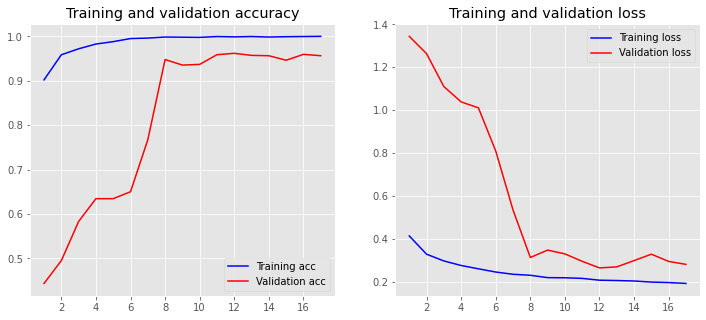

In [55]:
loss, accuracy = AlexNet.evaluate(np.array(X_train, np.float32), np.array(list(map(int,y_train)), np.float32), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = AlexNet.evaluate(np.array(X_test, np.float32), np.array(list(map(int,y_test)), np.float32), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist)

Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

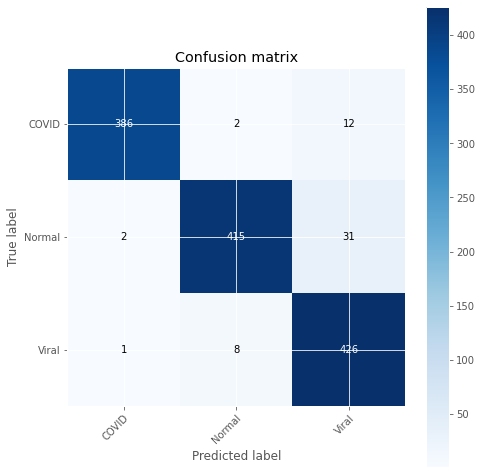

In [56]:
y_pred_AlexNet=AlexNet.predict_classes(np.array(X_test, np.float32))
confusion_mtx=confusion_matrix(y_test,y_pred_AlexNet)
class_names=['COVID', 'Normal', 'Viral']
plot_confusion_matrix(y_pred_AlexNet, y_test, classes = class_names,title = 'Confusion matrix')

## Learning Rate 0.001

In [102]:
opt = keras.optimizers.Adam(lr=0.001)
AlexNet.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [104]:
hist = AlexNet.fit(np.array(X_train, np.float32),
                   np.array(list(map(int,y_train)), np.float32),
                   epochs=1000,
                   verbose=1,
                  validation_data=(np.array(X_test, np.float32), np.array(list(map(int,y_test)), np.float32)),
                  callbacks = [monitor])

Epoch 1/1000
82/82 [==============================] - 241s 3s/step - loss: 0.4175 - accuracy: 0.8828 - val_loss: 0.5613 - val_accuracy: 0.7997
Epoch 2/1000
82/82 [==============================] - 240s 3s/step - loss: 0.3003 - accuracy: 0.9351 - val_loss: 0.7391 - val_accuracy: 0.6610
Epoch 3/1000
82/82 [==============================] - 244s 3s/step - loss: 0.2650 - accuracy: 0.9458 - val_loss: 0.3200 - val_accuracy: 0.9072
Epoch 4/1000
82/82 [==============================] - 241s 3s/step - loss: 0.2375 - accuracy: 0.9516 - val_loss: 0.3701 - val_accuracy: 0.8878
Epoch 5/1000
82/82 [==============================] - 251s 3s/step - loss: 0.2136 - accuracy: 0.9612 - val_loss: 0.2947 - val_accuracy: 0.9135
Epoch 6/1000
82/82 [==============================] - 248s 3s/step - loss: 0.1899 - accuracy: 0.9635 - val_loss: 0.5411 - val_accuracy: 0.7935
Epoch 7/1000
82/82 [==============================] - 245s 3s/step - loss: 0.1849 - accuracy: 0.9639 - val_loss: 0.3670 - val_accuracy: 0.8722

Training Accuracy: 0.9159
Testing Accuracy:  0.8924


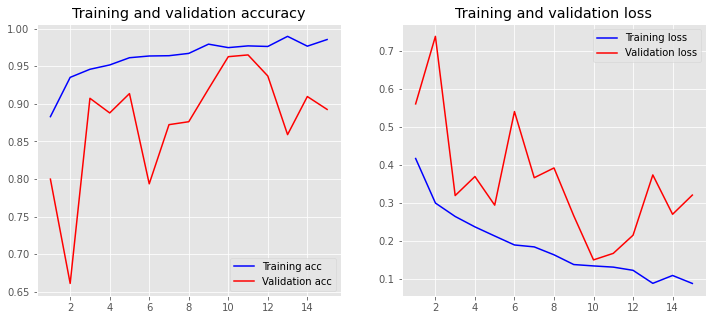

In [107]:
loss, accuracy = AlexNet.evaluate(np.array(X_train, np.float32), np.array(list(map(int,y_train)), np.float32), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = AlexNet.evaluate(np.array(X_test, np.float32), np.array(list(map(int,y_test)), np.float32), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist)

Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

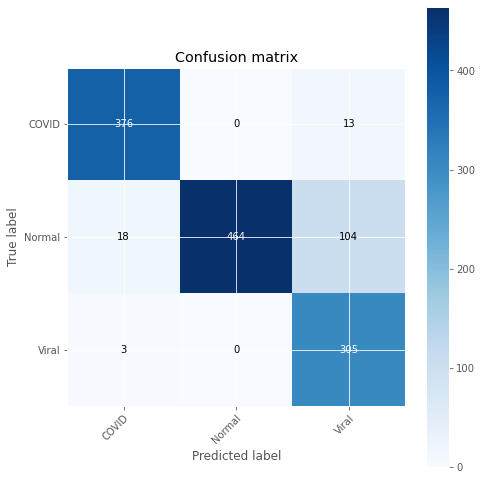

In [121]:
y_pred_AlexNet=AlexNet.predict_classes(np.array(X_test, np.float32))
confusion_mtx=confusion_matrix(y_test,y_pred_AlexNet)
class_names=['COVID', 'Normal', 'Viral']
plot_confusion_matrix(y_pred_AlexNet, y_test, classes = class_names,title = 'Confusion matrix')

## Learning Rate 0.01

In [32]:
opt = keras.optimizers.Adam(lr=0.01)
AlexNet.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [33]:
hist = AlexNet.fit(np.array(X_train, np.float32),
                   np.array(list(map(int,y_train)), np.float32),
                   epochs=1000,
                   verbose=1,
                  validation_data=(np.array(X_test, np.float32), np.array(list(map(int,y_test)), np.float32)),
                  callbacks = [monitor])

Epoch 1/1000
82/82 [==============================] - 249s 3s/step - loss: 0.5204 - accuracy: 0.8144 - val_loss: 82.6369 - val_accuracy: 0.3032
Epoch 2/1000
82/82 [==============================] - 244s 3s/step - loss: 0.2786 - accuracy: 0.9101 - val_loss: 4.5470 - val_accuracy: 0.4170
Epoch 3/1000
82/82 [==============================] - 244s 3s/step - loss: 0.2152 - accuracy: 0.9324 - val_loss: 1.4278 - val_accuracy: 0.6446
Epoch 4/1000
82/82 [==============================] - 265s 3s/step - loss: 0.1719 - accuracy: 0.9466 - val_loss: 0.2683 - val_accuracy: 0.9182
Epoch 5/1000
82/82 [==============================] - 242s 3s/step - loss: 0.1443 - accuracy: 0.9531 - val_loss: 2.0683 - val_accuracy: 0.5799
Epoch 6/1000
82/82 [==============================] - 241s 3s/step - loss: 0.1295 - accuracy: 0.9566 - val_loss: 3.1298 - val_accuracy: 0.5503
Epoch 7/1000
82/82 [==============================] - 242s 3s/step - loss: 0.1139 - accuracy: 0.9627 - val_loss: 0.9220 - val_accuracy: 0.591

Training Accuracy: 0.6562
Testing Accuracy:  0.6251


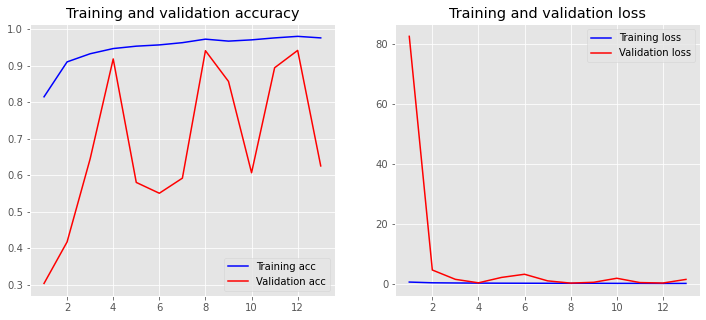

In [34]:
loss, accuracy = AlexNet.evaluate(np.array(X_train, np.float32), np.array(list(map(int,y_train)), np.float32), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = AlexNet.evaluate(np.array(X_test, np.float32), np.array(list(map(int,y_test)), np.float32), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist)

Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

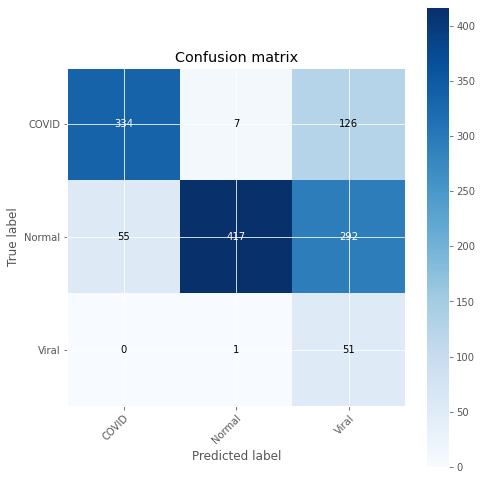

In [35]:
y_pred_AlexNet=AlexNet.predict_classes(np.array(X_test, np.float32))
confusion_mtx=confusion_matrix(y_test,y_pred_AlexNet)
class_names=['COVID', 'Normal', 'Viral']
plot_confusion_matrix(y_pred_AlexNet, y_test, classes = class_names,title = 'Confusion matrix')

## Learning Rate 0.1

In [43]:
opt = keras.optimizers.Adam(lr=0.1)
AlexNet.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [44]:
hist = AlexNet.fit(np.array(X_train, np.float32),
                   np.array(list(map(int,y_train)), np.float32),
                   epochs=1000,
                   verbose=1,
                  validation_data=(np.array(X_test, np.float32), np.array(list(map(int,y_test)), np.float32)),
                  callbacks = [monitor])

Epoch 1/1000
82/82 [==============================] - 239s 3s/step - loss: 0.4282 - accuracy: 0.8371 - val_loss: 54.9259 - val_accuracy: 0.3648
Epoch 2/1000
82/82 [==============================] - 246s 3s/step - loss: 0.2257 - accuracy: 0.9209 - val_loss: 2.9706 - val_accuracy: 0.5051
Epoch 3/1000
82/82 [==============================] - 241s 3s/step - loss: 0.1720 - accuracy: 0.9389 - val_loss: 0.3826 - val_accuracy: 0.9065
Epoch 4/1000
82/82 [==============================] - 248s 3s/step - loss: 0.1825 - accuracy: 0.9358 - val_loss: 1.4575 - val_accuracy: 0.6306
Epoch 5/1000
82/82 [==============================] - 237s 3s/step - loss: 0.1653 - accuracy: 0.9381 - val_loss: 0.4606 - val_accuracy: 0.8745
Epoch 6/1000
82/82 [==============================] - 283s 3s/step - loss: 0.1302 - accuracy: 0.9562 - val_loss: 0.4187 - val_accuracy: 0.8815
Epoch 7/1000
82/82 [==============================] - 235s 3s/step - loss: 0.1135 - accuracy: 0.9593 - val_loss: 1.1793 - val_accuracy: 0.739

Training Accuracy: 0.8475
Testing Accuracy:  0.8176


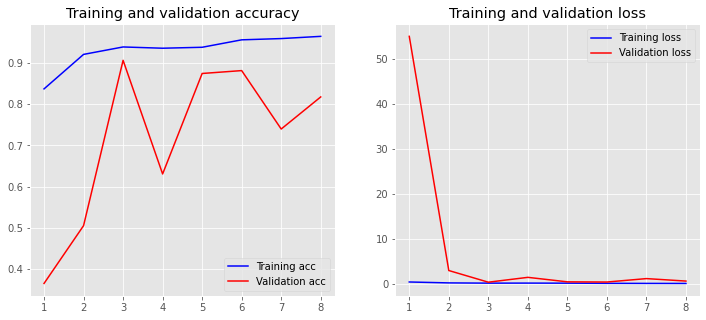

In [45]:
loss, accuracy = AlexNet.evaluate(np.array(X_train, np.float32), np.array(list(map(int,y_train)), np.float32), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = AlexNet.evaluate(np.array(X_test, np.float32), np.array(list(map(int,y_test)), np.float32), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist)

Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

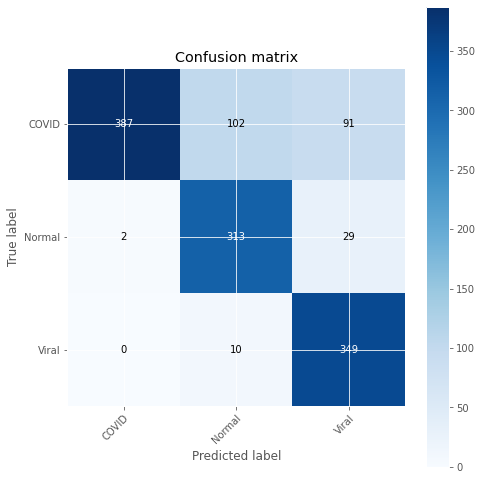

In [46]:
y_pred_AlexNet=AlexNet.predict_classes(np.array(X_test, np.float32))
confusion_mtx=confusion_matrix(y_test,y_pred_AlexNet)
class_names=['COVID', 'Normal', 'Viral']
plot_confusion_matrix(y_pred_AlexNet, y_test, classes = class_names,title = 'Confusion matrix')

## Learning Rate 1

In [47]:
opt = keras.optimizers.Adam(lr=1)
AlexNet.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [48]:
hist = AlexNet.fit(np.array(X_train, np.float32),
                   np.array(list(map(int,y_train)), np.float32),
                   epochs=1000,
                   verbose=1,
                  validation_data=(np.array(X_test, np.float32), np.array(list(map(int,y_test)), np.float32)),
                  callbacks = [monitor])

Epoch 1/1000
82/82 [==============================] - 237s 3s/step - loss: 0.6634 - accuracy: 0.7591 - val_loss: 34.8225 - val_accuracy: 0.3032
Epoch 2/1000
82/82 [==============================] - 233s 3s/step - loss: 0.3125 - accuracy: 0.8894 - val_loss: 20.7735 - val_accuracy: 0.3422
Epoch 3/1000
82/82 [==============================] - 235s 3s/step - loss: 0.2514 - accuracy: 0.9205 - val_loss: 36.5752 - val_accuracy: 0.3429
Epoch 4/1000
82/82 [==============================] - 263s 3s/step - loss: 0.2772 - accuracy: 0.9070 - val_loss: 23.9306 - val_accuracy: 0.3313
Epoch 5/1000
82/82 [==============================] - 315s 4s/step - loss: 0.2133 - accuracy: 0.9301 - val_loss: 1.5949 - val_accuracy: 0.6882
Epoch 6/1000
82/82 [==============================] - 309s 4s/step - loss: 0.1815 - accuracy: 0.9347 - val_loss: 1.0864 - val_accuracy: 0.7210
Epoch 7/1000
82/82 [==============================] - 309s 4s/step - loss: 0.1931 - accuracy: 0.9262 - val_loss: 4.6214 - val_accuracy: 0.

Training Accuracy: 0.8352
Testing Accuracy:  0.8036


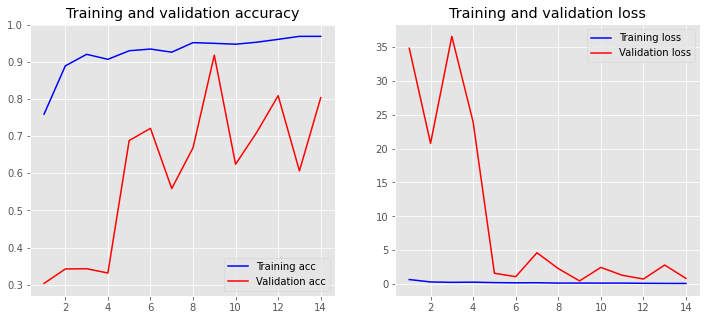

In [49]:
loss, accuracy = AlexNet.evaluate(np.array(X_train, np.float32), np.array(list(map(int,y_train)), np.float32), verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = AlexNet.evaluate(np.array(X_test, np.float32), np.array(list(map(int,y_test)), np.float32), verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist)

Confusion matrix, without normalization


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

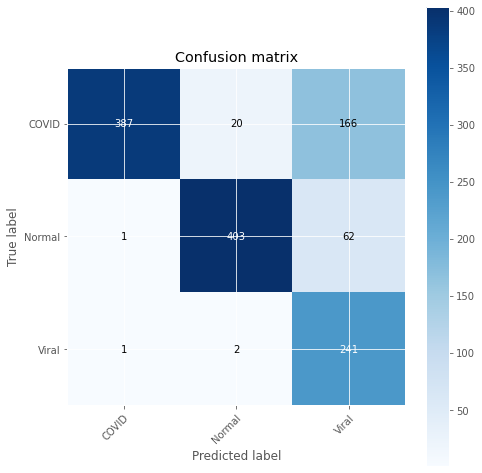

In [50]:
y_pred_AlexNet=AlexNet.predict_classes(np.array(X_test, np.float32))
confusion_mtx=confusion_matrix(y_test,y_pred_AlexNet)
class_names=['COVID', 'Normal', 'Viral']
plot_confusion_matrix(y_pred_AlexNet, y_test, classes = class_names,title = 'Confusion matrix')

In [84]:
y_test.count(2)

469